In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.esn import ESN
from adjoint_esn.rijke_esn import RijkeESN
from adjoint_esn.utils import preprocessing as pp
from adjoint_esn.utils.enums import eParam, get_eVar
from pathlib import Path
from adjoint_esn.rijke_galerkin.solver import Rijke
from scipy.integrate import odeint
from adjoint_esn.utils import signals as sig
import adjoint_esn.utils.visualizations as vis
from adjoint_esn.utils import errors,scalers
from scipy import signal
from functools import partial
from src.configs.config import get_config
import yaml
from adjoint_esn.validation import set_ESN
from adjoint_esn.utils.discretizations import finite_differences
import adjoint_esn.utils.solve_ode as solve_ode

In [49]:
# model_path = Path("../local_results/rijke/run_20231029_153121")
# sens_results1 = pp.unpickle_file(model_path / f"sensitivity_results_20231113_004058.pickle")[
#     0
# ]
# sens_results2 = pp.unpickle_file(model_path / f"sensitivity_results_20231112_231343.pickle")[
#     0
# ]

# sensitivity_results = sens_results1.copy()
# sensitivity_results["dJdp"]["true"]["adjoint"] = np.vstack((sens_results1["dJdp"]["true"]["adjoint"], sens_results2["dJdp"]["true"]["adjoint"]))
# sensitivity_results["dJdp"]["esn"]["adjoint"] = np.concatenate((sens_results1["dJdp"]["esn"]["adjoint"], sens_results2["dJdp"]["esn"]["adjoint"]), axis=1)
# sensitivity_results["J"]["true"] =  np.hstack((sens_results1["J"]["true"], sens_results2["J"]["true"]))
# sensitivity_results["J"]["esn"] = np.concatenate((sens_results1["J"]["esn"], sens_results2["J"]["esn"]), axis=1)
# sensitivity_results["beta_list"] = np.hstack((sens_results1["beta_list"], sens_results2["beta_list"]))

In [64]:
# model_path = Path("../local_results/rijke/run_20231029_153121")
# sensitivity_results = pp.unpickle_file(model_path / f"sensitivity_results_20231113_112743.pickle")[
#     0
# ]
# sensitivity_results["dJdp"]["true"]["adjoint"] = sensitivity_results["dJdp"]["true"]["adjoint"][:-1,:]
# sensitivity_results["dJdp"]["esn"]["adjoint"] = sensitivity_results["dJdp"]["esn"]["adjoint"][:,:-1,:]
# sensitivity_results["J"]["true"] = sensitivity_results["J"]["true"][:-1]
# sensitivity_results["J"]["esn"] = sensitivity_results["J"]["esn"][:,:-1]
# sensitivity_results["beta_list"] = sensitivity_results["beta_list"][:-1]
# pp.pickle_file(model_path / f"sensitivity_results_20231113_112743.pickle", sensitivity_results)

In [19]:
# model_path = Path("../local_results/rijke/run_20231029_153121")
# sensitivity_results = pp.unpickle_file(model_path / f"sensitivity_results_20231113_130717.pickle")[
#     0
# ]
# sensitivity_results

In [2]:
def load_config(experiment_path):
       with open(experiment_path/'config.yml', 'r') as file:
         config = yaml.unsafe_load(file)
         return config

experiment_path=Path('../local_results/rijke/run_20231029_153121') 
config = load_config(experiment_path)
results = pp.unpickle_file(experiment_path / 'results.pickle')[0]
print(config)
print(results)

model:
  connectivity: 20
  input_only_mode: false
  input_vars: eta_mu_v_tau
  input_weights_mode: sparse_grouped_rijke
  network_dt: 0.01
  output_vars: eta_mu
  param_vars:
  - beta
  r2_mode: false
  reservoir_size: 1200
  reservoir_weights_mode: erdos_renyi1
  type: rijke
  u_f_order: 1
  washout_time: 4
random_seed: 41
simulation:
  N_g: 4
  beta_list:
  - 1.0
  - 2.0
  - 3.0
  - 4.0
  - 5.0
  noise_level: 0
  sim_dt: 0.001
  sim_time: 800
  tau_list:
  - 0.1
  - 0.15
  - 0.2
  - 0.25
  - 0.3
  transient_time: 200
train:
  regime_selection: 20
  tikhonov: 0.001
  time: 8
val:
  error_measure: rel_L2
  fold_time: 4
  hyperparameters:
    input_scaling:
      max: 5.0
      min: 0.01
      scale: log10
    leak_factor:
      max: 1.0
      min: 0.01
      scale: log10
    parameter_normalization_mean:
      beta:
        max: 10.0
        min: -10.0
        scale: uniform
    parameter_normalization_var:
      beta:
        max: 10.0
        min: 0.01
        scale: log10
    spect

## Data generation

In [3]:
integrator = 'odeint'

# number of galerkin modes
N_g = config.simulation.N_g

# simulation options
sim_time = config.simulation.sim_time
sim_dt = config.simulation.sim_dt

# directory to search for simulation data, if the data doesn't exist, 
# then it will simulate the system
data_dir=Path('..\data')

# which regimes to use for training and validation
train_param_list = results["training_parameters"]

# add_param_list = np.array([[6.0, 0.2],
#                            [7.0, 0.2],
#                            [8.0, 0.2],
#                            [9.0, 0.2]])

# train_param_list = np.vstack((train_param_list, add_param_list))      
#                    
train_idx_list = np.arange(len(train_param_list))

transient_time = config.simulation.transient_time

noise_level = config.simulation.noise_level
random_seed = config.random_seed

# network time step
network_dt = config.model.network_dt

washout_time = config.model.washout_time

# which states to use as input and output
# for standard ESN these should be the same, e.g. both 'eta_mu'
# for Rijke ESN, input and output should be 'eta_mu_v_tau' and 'eta_mu' respectively
input_vars = config.model.input_vars
eInputVar = get_eVar(input_vars,N_g)
output_vars = config.model.output_vars
eOutputVar = get_eVar(output_vars,N_g)

# which system parameter is passed to the ESN
param_vars=config.model.param_vars

# if using Rijke ESN what is the order of u_f(t-tau) in the inputs,
# [u_f(t-tau), u_f(t-tau)^2 ..., u_f(t-tau)^(u_f_order)]
u_f_order = config.model.u_f_order

# length of training time series
train_time = config.train.time

loop_names=['train']
loop_times = [train_time]

DATA = {}
for loop_name in loop_names:
    DATA[loop_name]={'u_washout':[],'p_washout':[],'u':[],'p':[],'y':[],'t':[]}

for p_idx, p in enumerate(train_param_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir,integrator=integrator)

    regime_data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        loop_names=loop_names,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order,
                        noise_level=noise_level,
                        random_seed=random_seed)
    
    for loop_name in loop_names:
        [DATA[loop_name][var].append(regime_data[loop_name][var]) for var in DATA[loop_name].keys()]

# dimension of the inputs
dim = DATA["train"]["u"][0].shape[1]

### Plot data

In [ ]:
len_p_list=len(train_param_list)
plt_idx = [eInputVar.eta_1,eInputVar.eta_2,eInputVar.mu_1,eInputVar.mu_2,eInputVar.v_tau]
for p_idx in range(len_p_list):
    plt.figure(figsize = (15,3),constrained_layout=True)
    for j, k in enumerate(plt_idx):
        plt.subplot(1,len(plt_idx),j+1)
        vis.plot_lines(DATA["train"]["t"][p_idx],DATA["train"]["u"][p_idx][:,k],
                   title=f"beta = {train_param_list[p_idx][eParam.beta]}, tau = {train_param_list[p_idx][eParam.tau]},",
                   xlabel='t',
                   ylabel=k.name)
        plt.xlim([washout_time,20+washout_time])

## Train ESN

In [4]:
def create_ESN(ESN_dict, model_type, hyp_param_names, hyp_param_scales, hyp_params):
    if model_type == 'standard':
        my_ESN = ESN(**ESN_dict)
    elif model_type == 'rijke':
        my_ESN = RijkeESN(**ESN_dict)
    set_ESN(my_ESN,hyp_param_names,hyp_param_scales,hyp_params)
    return my_ESN

In [25]:
ESN_dict = {
        "reservoir_size": config.model.reservoir_size,
        "parameter_dimension": len(param_vars),
        "reservoir_connectivity": config.model.connectivity,
        "r2_mode": config.model.r2_mode,
        "input_only_mode": config.model.input_only_mode,
        "input_weights_mode": config.model.input_weights_mode,
        "reservoir_weights_mode": config.model.reservoir_weights_mode,
        "tikhonov": config.train.tikhonov,
    }
if config.model.type == "standard":
    ESN_dict["dimension"] = dim
elif config.model.type == "rijke":
    ESN_dict["N_g"] = config.simulation.N_g
    ESN_dict["x_f"] = 0.2
    ESN_dict["dt"] = config.model.network_dt
    ESN_dict["u_f_order"] = config.model.u_f_order

print('System dimension: ', dim)

top_idx = 0
hyp_param_names = []
hyp_params = []
for name in results.keys():
    if name not in ['training_parameters','validation_parameters','f','tikh']:
        if results[name].ndim == 2:
            hyp_param_names.extend([name]*results[name].shape[1])
            hyp_params.extend(results[name][top_idx])
        elif results[name].ndim == 1:
            hyp_param_names.extend([name])
            hyp_params.extend([results[name][top_idx]])
        
hyp_param_scales = ['uniform']*len(hyp_param_names)
# expand the ESN dict with the fixed seeds
ESN_dict["input_seeds"] = [20,21,22]
ESN_dict["reservoir_seeds"] = [23,24]
my_ESN = create_ESN(ESN_dict, config.model.type, hyp_param_names, hyp_param_scales, hyp_params)

System dimension:  9
Input normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Input weights of u_f(t-tau) are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.
Reservoir weights are rescaled with the new spectral radius.
Input weights of u_f(t-tau) are rescaled with the new input scaling.
Parameter normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input weights are rescaled with the new input scaling.


In [51]:
for key in ESN_dict.keys():
    print(f"{key}: {ESN_dict[key]}")
for hyp_param_name, hyp_param in zip(hyp_param_names, hyp_params):
    print(f"{hyp_param_name}: {hyp_param}")

reservoir_size: 1200
parameter_dimension: 1
reservoir_connectivity: 20
r2_mode: False
input_only_mode: False
input_weights_mode: sparse_grouped_rijke
reservoir_weights_mode: erdos_renyi1
tikhonov: 0.001
N_g: 4
x_f: 0.2
dt: 0.01
u_f_order: 1
leak_factor: 0.03632194032423177
input_scaling: 0.07900063819641595
u_f_scaling: 1.0500586305671449
parameter_normalization_var: 0.10922784754354686
spectral_radius: 0.012460700684349225
tikhonov: 1e-06
parameter_normalization_mean: -10.0


In [36]:
# need this for old results
my_ESN.parameter_normalization_var = 1/my_ESN.parameter_normalization_var

Parameter normalization is changed, training must be done again.


In [26]:
my_ESN.train(DATA["train"]["u_washout"], 
             DATA["train"]["u"], 
             DATA["train"]["y"],
             P_washout=DATA["train"]["p_washout"], 
             P_train=DATA["train"]["p"],
             train_idx_list=train_idx_list)

In [46]:
u_washout_auto = DATA["train"]["u_washout"][0]
u_washout_auto = np.repeat(DATA["train"]["u_washout"][0][0,:][None,:], [len(DATA["train"]["u_washout"][0])], axis = 0)

y0 = np.zeros((1,DATA["train"]["u_washout"][0].shape[1]))
eta_1_init = 0.1
y0[0,0] = eta_1_init
# y0[0,:2*N_g] = eta_1_init*np.random.randn(1, 2*N_g)

u_washout_auto = np.repeat(y0, [len(DATA["train"]["u_washout"][0])], axis = 0)

y_init = np.zeros(2*N_g+10)
y_init[:2*N_g] = y0[0,:2*N_g]
# y_init = eta_1_init*np.random.randn(2*N_g+10)

## Test ESN

Running solver.
Regime: beta = 0.5, tau = 0.12, Error: 1.2033563739295257
Running solver.
Regime: beta = 0.6, tau = 0.12, Error: 1.1759873119427646
Running solver.
Regime: beta = 0.7, tau = 0.12, Error: 1.1567394867298888
Running solver.
Regime: beta = 0.7999999999999999, tau = 0.12, Error: 1.1192620079568294
Running solver.
Regime: beta = 0.8999999999999999, tau = 0.12, Error: 1.0511778037136585


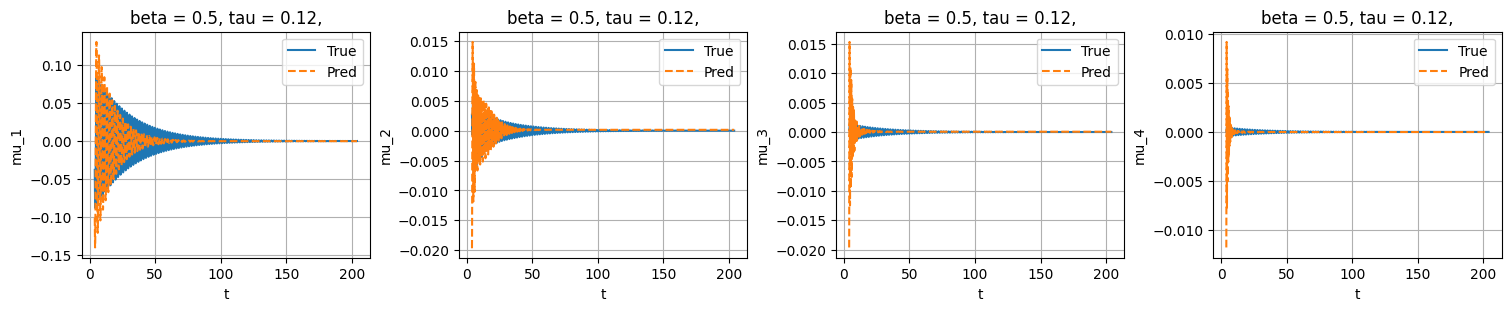

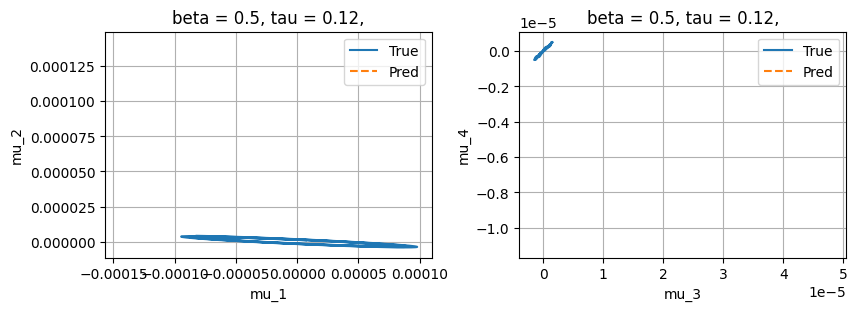

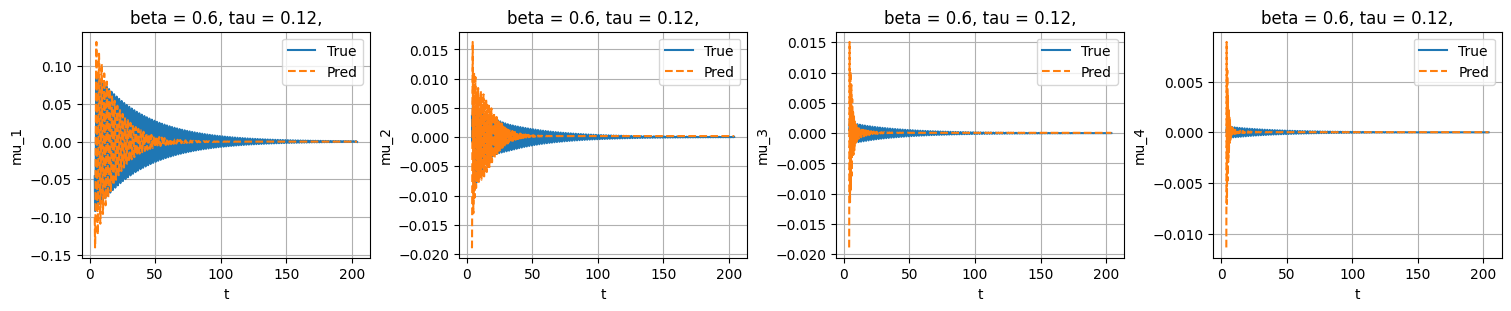

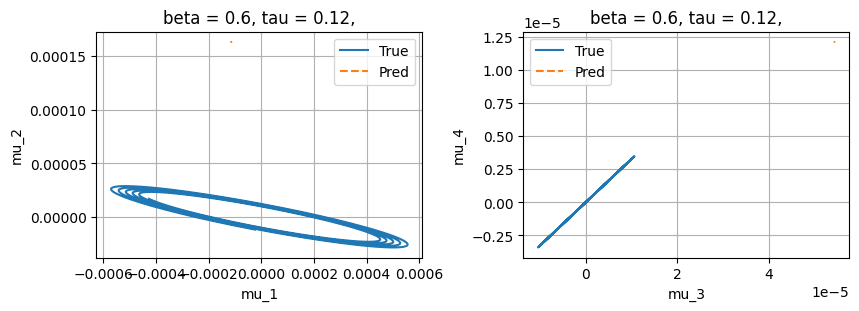

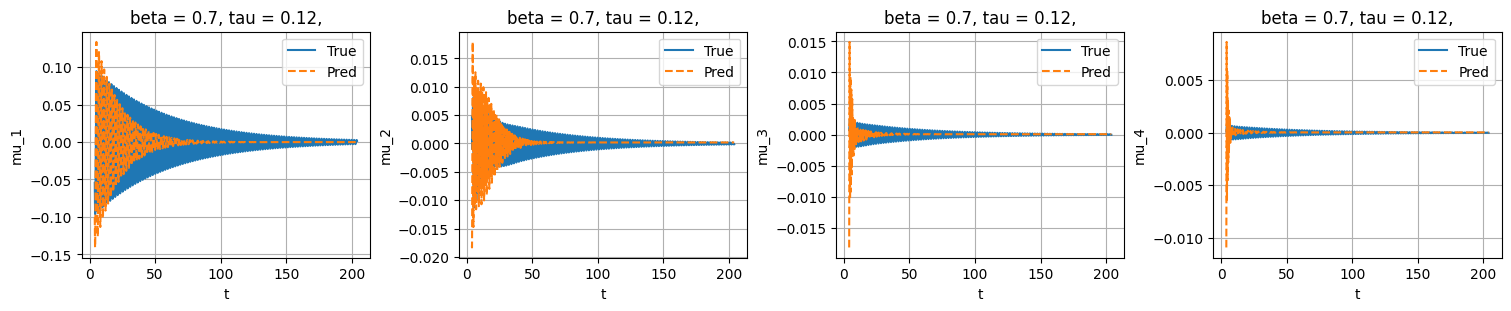

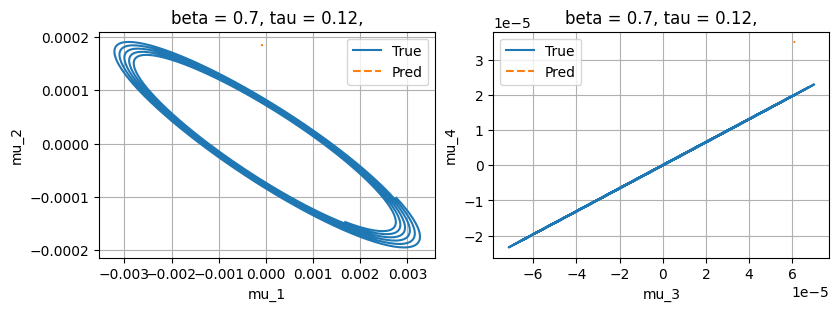

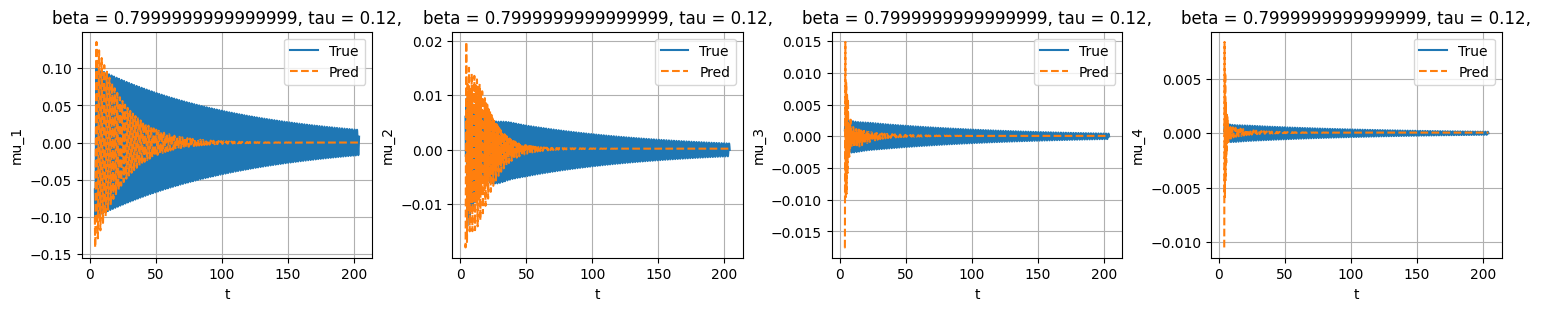

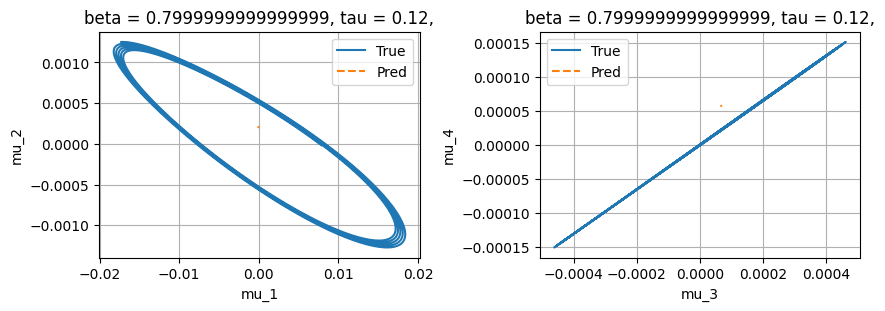

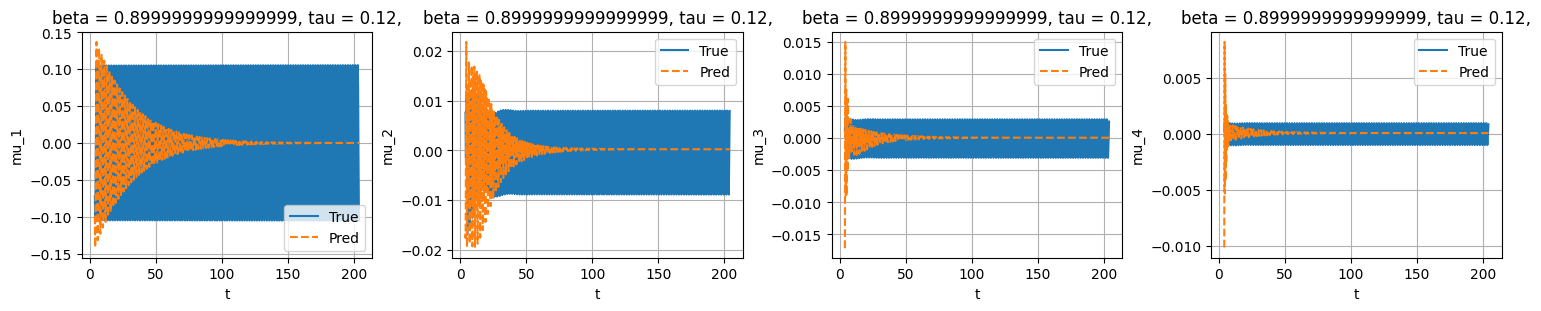

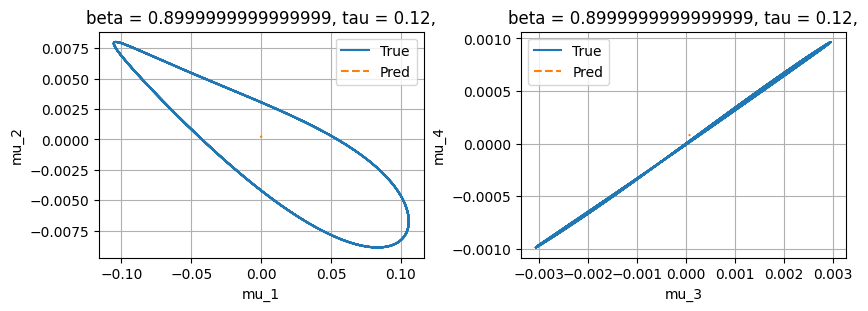

In [47]:
sim_time = 404
loop_times = [200]
beta_list = np.arange(0.5,1.0,0.1)
tau_list = [0.12]

plt_idx = [eOutputVar.mu_1,eOutputVar.mu_2,eOutputVar.mu_3,eOutputVar.mu_4]
plt_idx_pairs = [[eOutputVar.mu_1,eOutputVar.mu_2],
                 [eOutputVar.mu_3,eOutputVar.mu_4],]
phase_space_steps = pp.get_steps(10,network_dt)

error_measure = errors.rel_L2

p_list = pp.make_param_mesh([beta_list,tau_list])

for p_idx, p in enumerate(p_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir, y_init = y_init)

    data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=0, #transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order,
                        start_idxs=None)

    if hasattr(my_ESN,"tau"):
        my_ESN.tau = p_sim["tau"]

    for loop_name in data.keys():
        _, y_pred = my_ESN.closed_loop_with_washout(U_washout=u_washout_auto, #data[loop_name]["u_washout"], 
                                                    N_t=len(data[loop_name]["u"]), 
                                                    P_washout=data[loop_name]["p_washout"],  
                                                    P=data[loop_name]["p"])
        y_pred = y_pred[1:]

        regime_str = f'beta = {p_sim["beta"]}, tau = {p_sim["tau"]},'

        plt.figure(figsize = (15,3),constrained_layout=True)
        for j, k in enumerate(plt_idx):
            plt.subplot(1,len(plt_idx),j+1)
            vis.plot_lines(data[loop_name]["t"],data[loop_name]["y"][:,k],y_pred[:,k],
                       title=regime_str,
                       xlabel='t',
                       ylabel=k.name,
                       linestyle=['-','--'],
                       legend=['True','Pred'])
            
        plt.figure(figsize = (15,3),constrained_layout=True)
        for j, k in enumerate(plt_idx_pairs):
            plt.subplot(1,len(plt_idx),j+1)
            vis.plot_phase_space(data[loop_name]["y"][-phase_space_steps:],
                             y_pred[-phase_space_steps:],
                             idx_pair=k,
                             title=regime_str,
                             linestyle=['-','--'],
                             legend=['True','Pred'])
            plt.xlabel(k[0].name)
            plt.ylabel(k[1].name)

        print('Regime:',regime_str,'Error:', error_measure(data[loop_name]["y"],y_pred))

Omega =  3.28962581527727
Period =  1.9100000000000001
Omega =  3.28962581527727
Period =  1.9100000000000001


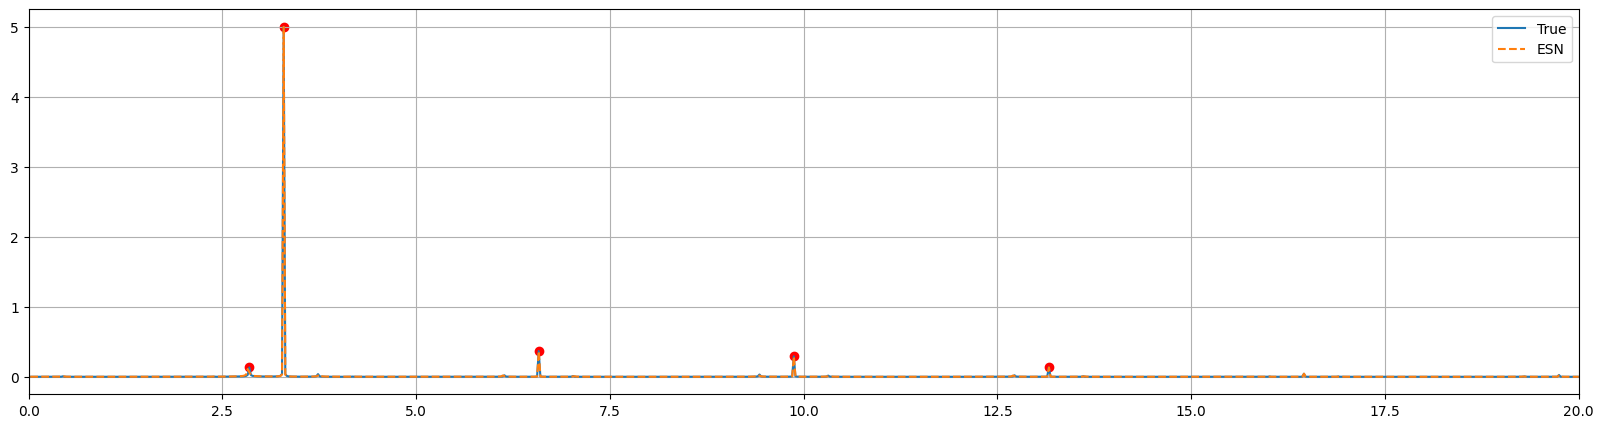

Omega peaks:  [ 2.8481298   3.29117221  6.58234442  9.87351663 13.16468884]
Period peaks:  [2.20607407 1.90910256 0.95455128 0.63636752 0.47727564]
Ratio of omega_0/ omega_1;  45/52
Ratio of omega_1/ omega_2;  1/2
Ratio of omega_2/ omega_3;  2/3


In [53]:
from adjoint_esn.utils import signals
from scipy.signal import find_peaks

def get_psd(dt, y, periodic = False):
    if periodic:
        T_period = signals.period(y, dt)
        omega_period = 2 * np.pi / T_period
        print("Omega = ", omega_period)
        print("Period = ", T_period)
        # take the maximum number of periods
        # the real period isn't an exact multiple of the sampling time
        # therefore, the signal doesn't repeat itself at exact integer indices
        # so calculating the number of time steps in each period
        # does not work in order to cut the signal at the maximum number of periods
        # that's why we will cut between peaks, which is a more reliable option
        # though still not exact
        min_dist = pp.get_steps(T_period - 0.1, dt)
        (start_pk_idx, end_pk_idx) = signals.periodic_signal_peaks(y, T=min_dist)
        y_pre_fft = y[start_pk_idx:end_pk_idx] # don't include end peak for continuous signal
    else:
        y_pre_fft = y

    # find psd
    omega, psd = signals.power_spectral_density(y_pre_fft, dt)

    # to get the harmonic frequency from the psd
    # psd_peaks = find_peaks(psd, threshold=0.1)[0] 
    # harmonic_freq = omega[psd_peaks][0]
    return omega, psd

periodic = True

# Plot power spectral density
omega, psd = get_psd(network_dt, data[loop_name]["y"][:,plt_idx[0]], periodic=periodic)
omega_pred, psd_pred = get_psd(network_dt, y_pred[:,plt_idx[0]], periodic=periodic)
plt.figure(figsize=(20,5))
plt.plot(omega, psd)
plt.plot(omega_pred, psd_pred,'--')
pks = signal.find_peaks(psd, threshold=0.05)[0]
pks_omega = omega[pks]
pks_psd = psd[pks]
plt.scatter(pks_omega,pks_psd, color='red')
plt.grid()
plt.legend(["True","ESN"])
plt.xlim([0,20])
plt.show()
print("Omega peaks: ", pks_omega)
pks_period = 2*np.pi / pks_omega
print("Period peaks: ", pks_period)

from fractions import Fraction
# rational approximation
print("Ratio of omega_0/ omega_1; ", Fraction((pks_omega[0]/pks_omega[1])).limit_denominator())
print("Ratio of omega_1/ omega_2; ", Fraction((pks_omega[1]/pks_omega[2])).limit_denominator())
print("Ratio of omega_2/ omega_3; ", Fraction((pks_omega[2]/pks_omega[3])).limit_denominator())
# print("Ratio of omega_3/ omega_4; ", Fraction((pks_omega[3]/pks_omega[4])).limit_denominator())

In [205]:
print(Fraction((pks_omega[4]/pks_omega[5])).limit_denominator())

5/6


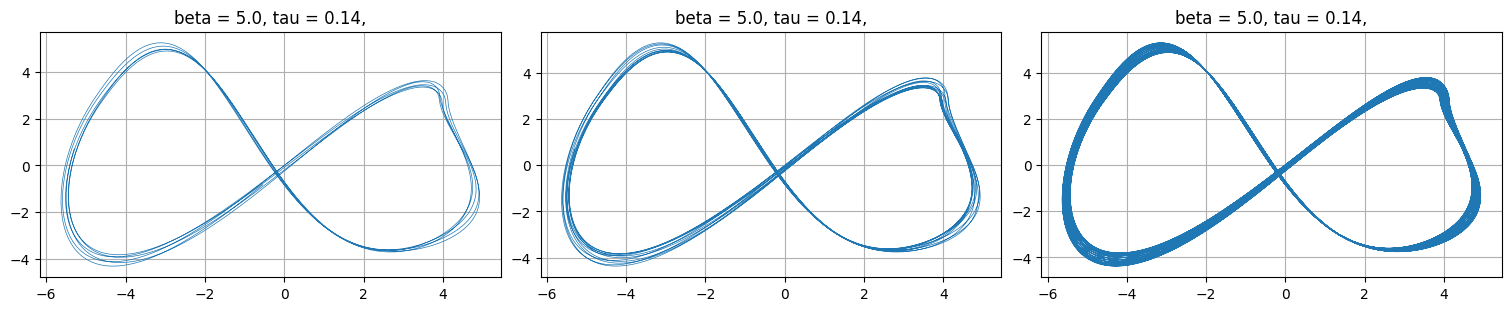

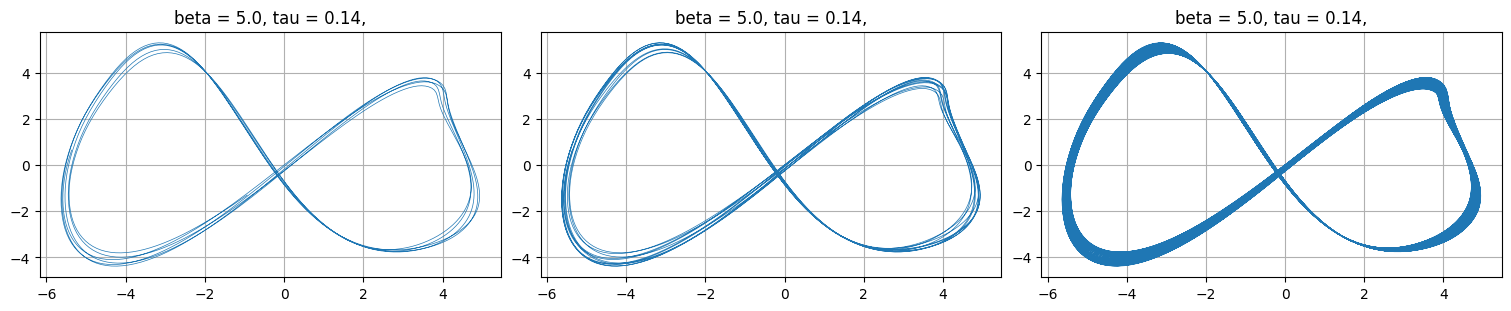

In [55]:
phase_space_steps1 = pp.get_steps(10,network_dt)
phase_space_steps2 = pp.get_steps(20,network_dt)
phase_space_steps3 = pp.get_steps(80,network_dt)

k = plt_idx_pairs[0]
lw = 0.5
plt.figure(figsize = (15,3),constrained_layout=True)
plt.subplot(1,3,1)
vis.plot_phase_space(data[loop_name]["y"][-phase_space_steps1:],idx_pair=k,title=regime_str,linewidth=[lw])

plt.subplot(1,3,2)
vis.plot_phase_space(data[loop_name]["y"][-phase_space_steps2:],idx_pair=k,title=regime_str,linewidth=[lw])

plt.subplot(1,3,3)
vis.plot_phase_space(data[loop_name]["y"][-phase_space_steps3:],idx_pair=k,title=regime_str,linewidth=[lw])

plt.figure(figsize = (15,3),constrained_layout=True)
plt.subplot(1,3,1)
vis.plot_phase_space(y_pred[-phase_space_steps1:],idx_pair=k,title=regime_str,linewidth=[lw])

plt.subplot(1,3,2)
vis.plot_phase_space(y_pred[-phase_space_steps2:],idx_pair=k,title=regime_str,linewidth=[lw])

plt.subplot(1,3,3)
vis.plot_phase_space(y_pred[-phase_space_steps3:],idx_pair=k,title=regime_str,linewidth=[lw])


## Triggering

Running solver.
Running solver.


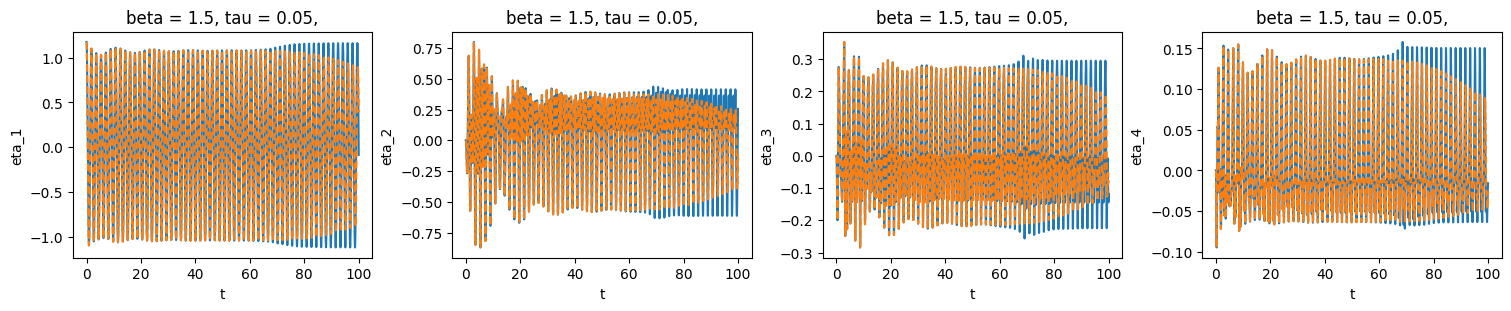

In [179]:
sim_time = 100
p_sim = {'beta':1.5, 'tau':0.05}
regime_str = f'beta = {p_sim["beta"]}, tau = {p_sim["tau"]},'

y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                            sim_time=sim_time,sim_dt=sim_dt,
                            data_dir=data_dir, eta_1_init = 1.176447586)
plt.figure(figsize = (15,3),constrained_layout=True) 
for j, k in enumerate(plt_idx):
    plt.subplot(1,len(plt_idx),j+1)
    vis.plot_lines(t_sim,y_sim[:,k],
                title=regime_str,
                xlabel='t',
                ylabel=k.name,
                linestyle=['-'])
    
y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                            sim_time=sim_time,sim_dt=sim_dt,
                            data_dir=data_dir, eta_1_init = 1.176447485)
# plt.figure(figsize = (15,3),constrained_layout=True)                          
for j, k in enumerate(plt_idx):
    plt.subplot(1,len(plt_idx),j+1)
    vis.plot_lines(t_sim,y_sim[:,k],
                title=regime_str,
                xlabel='t',
                ylabel=k.name,
                linestyle=['--'])


## Statistics

In [ ]:
sim_time = 400
loop_times = [100]

beta_list =  [7.5]
tau_list = [0.22]
p_list = pp.make_param_mesh([beta_list,tau_list])

# plt_idx = [eOutputVar.eta_1,eOutputVar.eta_2,eOutputVar.mu_1,eOutputVar.mu_2]
# plt_idx = [eOutputVar.eta_1,eOutputVar.eta_2,eOutputVar.eta_3,eOutputVar.eta_4]
plt_idx = [eOutputVar.mu_1,eOutputVar.mu_2,eOutputVar.mu_3,eOutputVar.mu_4]
for p_idx, p in enumerate(p_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)

    data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order)

    if hasattr(my_ESN,"tau"):
        my_ESN.tau = p_sim["tau"]
    for loop_name in data.keys():
        _, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                    N_t=len(data[loop_name]["u"]), 
                                                    P_washout=data[loop_name]["p_washout"],  
                                                    P=data[loop_name]["p"])
        y_pred = y_pred[1:]
        regime_str = f"beta = {p_list[p_idx][eParam.beta]}, tau = {p_list[p_idx][eParam.tau]},"

        plt.figure(figsize = (15,3),constrained_layout=True)
        for j, k in enumerate(plt_idx):
            plt.subplot(1,len(plt_idx),j+1)
            vis.plot_statistics(data[loop_name]["y"][:,k],y_pred[:,k],
                                title=regime_str,
                                xlabel=k.name,
                                ylabel='PDF',
                                linestyle=['-','--'],
                                legend=['True','Pred'])

## Stability analysis

In [73]:
import adjoint_esn.utils.lyapunov as lyap
from adjoint_esn.rijke_galerkin.solver import Rijke

sim_time = 5200
sim_dt = 1e-3
loop_times = [3000]
transient_time_ly = 200

p_sim = {'beta':7.2, 'tau':0.2}

rjk = Rijke(
    N_g=4,
    N_c=10,
    c_1=0.1,
    c_2=0.06,
    beta=p_sim["beta"],
    x_f=0.2,
    tau=p_sim["tau"],
    heat_law='kings_poly',
    damping='modal',
)
y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                            sim_time=sim_time,sim_dt=sim_dt,
                            data_dir=data_dir,
                            integrator=integrator)
N_transient = pp.get_steps(transient_time,sim_dt)
y_bar = y_sim[N_transient:,:]
t_bar = t_sim[N_transient:]

N_washout = pp.get_steps(washout_time,sim_dt)
N_loop = pp.get_steps(loop_times[0],sim_dt)+1
y_bar = y_bar[N_washout:N_washout + N_loop,:]
t_bar = t_bar[N_washout:N_washout + N_loop]-t_bar[N_washout]
y_bar = y_bar[:,:rjk.N_dim]

data = pp.create_dataset(y_sim,t_sim,p_sim,
                    network_dt=network_dt,
                    transient_time=transient_time,
                    washout_time=washout_time,
                    loop_times=loop_times,
                    input_vars=input_vars,
                    output_vars=output_vars,
                    param_vars=param_vars,
                    N_g=N_g,
                    u_f_order=u_f_order)

# if hasattr(my_ESN,"tau"):
#     my_ESN.tau = p_sim["tau"]
# for loop_name in data.keys():
#     X_pred, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
#                                                 N_t=len(data[loop_name]["u"]), 
#                                                 P_washout=data[loop_name]["p_washout"],  
#                                                 P=data[loop_name]["p"])

LEs_true, FTLE_true, QQ_true, RR_true = lyap.calculate_LEs(sys=rjk,
                                 sys_type='continuous',
                                 X=y_bar,
                                 t=t_bar,
                                 transient_time=transient_time_ly,
                                 dt=sim_dt,
                                 target_dim=None,
                                 norm_step=1)
LEs_target = LEs_true[-1]
print('Lyapunov exponents true:', LEs_target)
print('Lyapunov time true:', 1/LEs_target[0])
# CLVs, angles, FTCLE = lyap.calculate_CLVs(QQ,RR,dt)

# LEs, FTLE, QQ, RR = lyap.calculate_LEs(sys=my_ESN,
#                                  sys_type='ESN',
#                                  X=X_pred,
#                                  t=data[loop_name]["t"]-data[loop_name]["t"][0],
#                                  transient_time=transient_time_ly,
#                                  dt=network_dt,
#                                  target_dim=my_ESN.N_dim,
#                                  norm_step=1)
# LEs_target = LEs[-1]
# print('Lyapunov exponents:', LEs_target)
# print('Lyapunov time:', 1/LEs_target[0])
# CLVs, angles, FTCLE = lyap.calculate_CLVs(QQ,RR,dt)

Simulation not long enough: 5200>2200.0
Running solver.


KeyboardInterrupt: 

## Bifurcation diagram

In [ ]:
sim_time = 300
loop_times = [100]

beta_list = np.arange(0.5,9.0,0.1)
tau_list = [0.2]

if len(beta_list) > 1 and len(tau_list) == 1:
    vary_param = 'beta'
elif len(beta_list) == 1 and len(tau_list) > 1:
    vary_param = 'tau'
else:
    raise ValueError("For this plot one parameter needs to be varying and the other fixed.")
p_list = pp.make_param_mesh([beta_list,tau_list])

vary_param_train = list(set(train_param_list[train_idx_list,eParam[vary_param]]))

plt_idx = [eOutputVar.eta_1,eOutputVar.eta_2,eOutputVar.mu_1,eOutputVar.mu_2]

fig, ax = plt.subplots(nrows=2, 
                        ncols=len(plt_idx), 
                        figsize=(15,5), 
                        constrained_layout=True)

# track minimum and maximum values of the peaks 
pks_min = np.inf*np.ones((len(p_list),len(plt_idx)))   
pks_max = -np.inf*np.ones((len(p_list),len(plt_idx)))   

for p_idx, p in enumerate(p_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)

    data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order)
    
    loop_name = list(data.keys())[0]

    if hasattr(my_ESN,"tau"):
        my_ESN.tau = p_sim["tau"]
    
    _, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                N_t=len(data[loop_name]["u"]), 
                                                P_washout=data[loop_name]["p_washout"],  
                                                P=data[loop_name]["p"])
    y_pred = y_pred[1:]

    for j, k in enumerate(plt_idx):
        plt.sca(ax[0,j])
        pks_true = vis.plot_bifurcation_diagram(p_sim[vary_param], data[loop_name]["y"][:,k], 
                                        color='tab:blue', 
                                        marker='*', 
                                        linestyle='None')
        min_pks_true = np.min(pks_true)
        max_pks_true = np.max(pks_true)

        plt.sca(ax[1,j])
        pks_pred = vis.plot_bifurcation_diagram(p_sim[vary_param], y_pred[:,k],
                                        color='tab:orange', 
                                        marker='*', 
                                        linestyle='None')
        min_pks_pred = np.min(pks_pred)
        max_pks_pred = np.max(pks_pred)

        pks_min[p_idx,j] = min(pks_min[p_idx,j], min(min_pks_true,min_pks_pred))
        pks_max[p_idx,j] = max(pks_max[p_idx,j], max(max_pks_true,max_pks_pred))

for j, k in enumerate(plt_idx):
    for i in range(ax.shape[0]):
        ylims = [np.min(pks_min[:,j]),np.max(pks_max[:,j])]
        ax[i,j].set_ylim(ylims)
        ax[i,j].set_xlabel(vary_param)
        ax[i,j].set_ylabel(f"Local maxima of {k.name}")
        ax[i,j].vlines(vary_param_train, ymin=ylims[0], ymax=ylims[1], color = "grey", linestyles='dashed')
        ax[i,j].grid()

## Hopf bifurcation curve

In [7]:
def acoustic_energy(y, N_g):
    return 1/4*np.mean(np.sum(y[:,:2*N_g]**2, axis = 1))

In [ ]:
sim_time = 400
loop_times = [100]

beta_list = np.arange(0.2,2.5,0.1)
tau_list = np.arange(0.05,0.1,0.01)

def energy_decreased(y, N_g, percent_threshold = 5):
    half_steps = int(np.round(len(y)/2))
    e1 = acoustic_energy(y[:half_steps],N_g)
    e2 = acoustic_energy(y[half_steps:],N_g)
    return e1-e2 > (percent_threshold/100)*e1 or e2 < 5e-4

percent_threshold = 5
p_energy_decreased = partial(energy_decreased, N_g=N_g, percent_threshold=percent_threshold)
bifn_point_true = np.zeros(len(tau_list))
bifn_point_pred = np.zeros(len(tau_list))

for tau_idx, tau in enumerate(tau_list):
    for beta_idx, beta in enumerate(beta_list): 
        p_sim = {'beta':beta, 'tau':tau}
        y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                    sim_time=sim_time,sim_dt=sim_dt,
                                    data_dir=data_dir)

        data = pp.create_dataset(y_sim,t_sim,p_sim,
                            network_dt=network_dt,
                            transient_time=transient_time,
                            washout_time=washout_time,
                            loop_times=loop_times,
                            input_vars=input_vars,
                            output_vars=output_vars,
                            param_vars=param_vars,
                            N_g=N_g,
                            u_f_order=u_f_order)
        
        loop_name = list(data.keys())[0]

        if hasattr(my_ESN,"tau"):
            my_ESN.tau = p_sim["tau"]

        y0 = np.zeros((1,data[loop_name]["u_washout"].shape[1]))
        y0[0] = 1.0
        u_washout_auto = np.repeat(y0, [len(data[loop_name]["u_washout"])], axis = 0)
        transient_steps = pp.get_steps(transient_time, network_dt)
        # add the transient time that will be discarded later
        N_t_long = transient_steps + len(data[loop_name]["u"])
        p_long0 = np.zeros((1,data[loop_name]["p"].shape[1]))
        p_long0[0] = data[loop_name]["p"][0]
        p_long = np.repeat(p_long0, [N_t_long], axis = 0)
        
        _, y_pred = my_ESN.closed_loop_with_washout(U_washout=u_washout_auto, 
                                                        N_t=N_t_long, 
                                                        P_washout=data[loop_name]["p_washout"],  
                                                        P=p_long)
        y_pred = y_pred[1:]
        y_pred = y_pred[transient_steps:, :]

        if p_energy_decreased(data[loop_name]["y"]):
            bifn_point_true[tau_idx] = beta
            print(f'True bifn pt: beta = {p_sim["beta"]}, tau = {p_sim["tau"]}')
        if p_energy_decreased(y_pred):
            bifn_point_pred[tau_idx] = beta
            print(f'Pred bifn pt: beta = {p_sim["beta"]}, tau = {p_sim["tau"]}')
        if not p_energy_decreased(data[loop_name]["y"]) and not p_energy_decreased(y_pred):
            break
        
plt.figure(figsize=(5,5))
vis.plot_reverse_lines(bifn_point_true,bifn_point_pred,y=tau_list,
                       linestyle=['-','--'],
                       xlabel='beta',
                       ylabel='tau')

## Sensitivity

In [8]:
def true_direct_sensitivity(my_rijke, t_bar, y_bar, integrator='odeint'):
    dt = t_bar[1]-t_bar[0]
    # direct problem
    dir0 = np.zeros(2*my_rijke.N_dim+2)
    dir = solve_ode.integrate(my_rijke.direct_ode,
                              dir0,
                              t_bar,
                              integrator=integrator,
                              args=(t_bar,1/dt,y_bar))
    dJdp = 1/t_bar[-1]*dir[-1,-2:]
    return dJdp

def true_adjoint_sensitivity(my_rijke, t_bar, y_bar, integrator='odeint'):
    dt = t_bar[1]-t_bar[0]
    # adjoint problem
    adjT = np.zeros(my_rijke.N_dim+2)
    adj = solve_ode.integrate(my_rijke.adjoint_ode,
                              adjT,
                              np.flip(t_bar),
                              integrator=integrator,
                              args =(t_bar,1/dt,y_bar))
    dJdp  = 1/t_bar[-1]*adj[-1,-2:]
    return dJdp

def true_finite_difference_sensitivity(my_rijke, t_bar, y_bar, h, h_tau, method, integrator='odeint'):
    # Calculate numerically
    # Find perturbed solutions (in beta)
    dJdp = np.zeros((2,))

    # left solution with beta = beta-h
    my_rijke_beta_left = Rijke(N_g=my_rijke.N_g,N_c=my_rijke.N_c,c_1=0.1,c_2=0.06,beta=my_rijke.beta-h,x_f=my_rijke.x_f,tau=my_rijke.tau,
                     heat_law="kings_poly",damping="modal")

    y_bar_beta_left =  solve_ode.integrate(my_rijke_beta_left.ode,
                                           y_bar[0,:my_rijke.N_dim],
                                           t_bar,
                                           integrator=integrator)
    J_beta_left = acoustic_energy(y_bar_beta_left[1:,:], my_rijke.N_g)
        
    # right solution with beta = beta+h
    my_rijke_beta_right = Rijke(N_g=my_rijke.N_g,N_c=my_rijke.N_c,c_1=0.1,c_2=0.06,beta=my_rijke.beta+h,x_f=my_rijke.x_f,tau=my_rijke.tau,
                     heat_law="kings_poly",damping="modal")
    
    y_bar_beta_right = solve_ode.integrate(my_rijke_beta_right.ode,
                                           y_bar[0,:my_rijke.N_dim],
                                           t_bar,
                                           integrator=integrator)
    J_beta_right = acoustic_energy(y_bar_beta_right[1:,:], my_rijke.N_g)

    # left solution with tau = tau-h
    my_rijke_tau_left = Rijke(N_g=my_rijke.N_g,N_c=my_rijke.N_c,c_1=0.1,c_2=0.06,beta=my_rijke.beta,x_f=my_rijke.x_f,tau=my_rijke.tau-h_tau,
                     heat_law="kings_poly",damping="modal")

    y_bar_tau_left = solve_ode.integrate(my_rijke_tau_left.ode,
                                         y_bar[0,:my_rijke.N_dim],
                                         t_bar,
                                         integrator=integrator)
    J_tau_left = acoustic_energy(y_bar_tau_left[1:,:], my_rijke.N_g)
        
    # # right solution with tau = tau+h
    my_rijke_tau_right = Rijke(N_g=my_rijke.N_g,N_c=my_rijke.N_c,c_1=0.1,c_2=0.06,beta=my_rijke.beta,x_f=my_rijke.x_f,tau=my_rijke.tau+h_tau,
                     heat_law="kings_poly",damping="modal")
    
    y_bar_tau_right = solve_ode.integrate(my_rijke_tau_right.ode,
                                          y_bar[0,:my_rijke.N_dim],
                                          t_bar,
                                          integrator=integrator)
    J_tau_right = acoustic_energy(y_bar_tau_right[1:,:], my_rijke.N_g)

    # define which finite difference method to use
    finite_difference = partial(finite_differences, method=method)

    J = acoustic_energy(y_bar[1:,:],my_rijke.N_g)
    dJdp[eParam.beta] = finite_difference(J, J_beta_right, J_beta_left, h)
    dJdp[eParam.tau] = finite_difference(J, J_tau_right, J_tau_left, h_tau)
    return dJdp


In [9]:
n_esns = 1
# generate and train ESN realisations
ESN_list = [None]*n_esns
ESN_dict["verbose"] = False
for esn_idx in range(n_esns):
    ESN_dict["input_seeds"] = [5*esn_idx, 5*esn_idx+1, 5*esn_idx+2]
    if not config.model.input_only_mode:
        ESN_dict["reservoir_seeds"] = [5*esn_idx+3, 5*esn_idx+4]
    my_ESN = create_ESN(ESN_dict, config.model.type, hyp_param_names, hyp_param_scales, hyp_params)
    my_ESN.train(DATA["train"]["u_washout"], 
             DATA["train"]["u"], 
             DATA["train"]["y"],
             P_washout=DATA["train"]["p_washout"], 
             P_train=DATA["train"]["p"],
             train_idx_list=train_idx_list)
    ESN_list[esn_idx] = my_ESN

In [162]:
y0 = np.zeros((1,DATA["train"]["u_washout"][0].shape[1]))
eta_1_init = 1.5
y0[0,0] = eta_1_init
# y0[0,:2*N_g] = eta_1_init*np.random.randn(1, 2*N_g)

u_washout_auto = np.repeat(y0, [len(DATA["train"]["u_washout"][0])], axis = 0)

y_init = np.zeros(2*N_g+10)
y_init[:2*N_g] = y0[0,:2*N_g]

In [12]:
integrator = 'odeint'
sim_time = 206
loop_times = [2]

beta_list = [5.0]
tau_list = np.arange(0.1,0.25,0.01)

if len(beta_list) > 1 and len(tau_list) == 1:
    vary_param = 'beta'
elif len(beta_list) == 1 and len(tau_list) > 1:
    vary_param = 'tau'
else:
    raise ValueError("For this plot one parameter needs to be varying and the other fixed.")
p_list = pp.make_param_mesh([beta_list,tau_list])

vary_param_train = list(set(train_param_list[train_idx_list,eParam[vary_param]]))

finite_difference_method = 'central'
methods = ['adjoint']
dJdp = {'true':{},'esn':{}}
for method_name in methods:
    dJdp['true'][method_name] = np.zeros((len(p_list),2))
    if config.model.type == 'standard':
        dJdp['esn'][method_name] = np.zeros((n_esns,len(p_list),len(param_vars)))
    elif config.model.type == 'rijke':
        dJdp['esn'][method_name] = np.zeros((n_esns,len(p_list),2))

J = {'true':np.zeros(len(p_list)),'esn':np.zeros((n_esns,len(p_list)))}

for p_idx, p in enumerate(p_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}

    regime_str = f'beta = {p_sim["beta"]}, tau = {p_sim["tau"]}'
    print('Regime:',regime_str)
    
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir,
                                integrator=integrator,
                                y_init=None)

    data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order)
    
    loop_name = list(data.keys())[0]

    N_transient = pp.get_steps(transient_time,sim_dt)
    y_bar = y_sim[N_transient:,:]
    t_bar = t_sim[N_transient:]

    N_washout = pp.get_steps(washout_time,sim_dt)
    N_loop = pp.get_steps(loop_times[0],sim_dt)+1
    y_bar = y_bar[N_washout:N_washout + N_loop,:]
    t_bar = t_bar[N_washout:N_washout + N_loop]-t_bar[N_washout]

    my_rijke = Rijke(
            N_g=N_g,
            N_c=10,
            c_1=0.1,
            c_2=0.06,
            beta=p_sim["beta"],
            x_f=0.2,
            tau=p_sim["tau"],
            heat_law="kings_poly",
            damping="modal",
        )
    # NOTE: because of downsampling, e.g. sim_dt = 1e-3, network_dt = 1e-2, y_bar[10] = data[loop_name]["y"][0]
    # how much does this, and downsampling overall, affect the accuracy?
    J["true"][p_idx] = acoustic_energy(y_bar[1:,:], N_g)
    for method_name in methods:
        if method_name == "direct":
            dJdp["true"][method_name][p_idx]= true_direct_sensitivity(my_rijke, t_bar, y_bar, integrator)
        elif method_name == "adjoint":
            dJdp["true"][method_name][p_idx]= true_adjoint_sensitivity(my_rijke, t_bar, y_bar, integrator)
        elif method_name == "numerical":
            dJdp["true"][method_name][p_idx]= true_finite_difference_sensitivity(my_rijke, t_bar, 
                                                                                 y_bar, 
                                                                                 h=1e-5, 
                                                                                 h_tau=network_dt, 
                                                                                 method=finite_difference_method,
                                                                                 integrator=integrator)
        print(f'True dJ/dp, {method_name} = {dJdp["true"][method_name][p_idx]}')
    
    for esn_idx in range(n_esns):
        my_ESN = ESN_list[esn_idx]
         # Wash-out phase to get rid of the effects of reservoir states initialised as zero
        # initialise the reservoir states before washout
        x0_washout = np.zeros(my_ESN.N_reservoir)
        N = len(data[loop_name]["u"])

        # N_transient_ = pp.get_steps(transient_time, network_dt)
        if hasattr(my_ESN,"tau"):
            my_ESN.tau = p_sim["tau"]
            # let the ESN run in open-loop for the wash-out
            # get the initial reservoir to start the actual open/closed-loop,
            # which is the last reservoir state
            X_tau = my_ESN.open_loop(x0=x0_washout, U=data[loop_name]["u_washout"], P=data[loop_name]["p_washout"])
            P_grad = np.vstack((data[loop_name]["p_washout"][-my_ESN.N_tau - 1 :, :], data[loop_name]["p"]))
            X_pred_grad, Y_pred_grad = my_ESN.closed_loop(X_tau[-my_ESN.N_tau - 1 :, :], N_t=N, P=P_grad)

            for method_name in methods:
                if method_name == "direct":
                    dJdp["esn"][method_name][esn_idx,p_idx]= my_ESN.direct_sensitivity(X_pred_grad, Y_pred_grad, N, X_tau)
                elif method_name == "adjoint":
                    dJdp["esn"][method_name][esn_idx,p_idx]= my_ESN.adjoint_sensitivity(X_pred_grad, Y_pred_grad, N, X_tau)
                elif method_name == "numerical":
                    dJdp["esn"][method_name][esn_idx,p_idx]= my_ESN.finite_difference_sensitivity(X_pred_grad, 
                                                                                                Y_pred_grad, 
                                                                                                X_tau, 
                                                                                                P_grad, 
                                                                                                N, 
                                                                                                method=finite_difference_method)
                print(f'ESN {esn_idx} dJ/dp, {method_name} = {dJdp["esn"][method_name][esn_idx,p_idx]}')
        else:
            X_pred_grad, Y_pred_grad = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"],
                                                                   N_t=N,
                                                                   P_washout=data[loop_name]["p_washout"],
                                                                   P=data[loop_name]["p"])
            # take out transient
            # X_pred_grad = X_pred_grad[N_transient_:,:]
            # Y_pred_grad = Y_pred_grad[N_transient_:,:]
            # N = len(data[loop_name]["u"])-N_transient_
            
            for method_name in methods:
                if method_name == "direct":
                    dJdp["esn"][method_name][esn_idx,p_idx]= my_ESN.direct_sensitivity(X_pred_grad, Y_pred_grad, N, N_g)
                elif method_name == "adjoint":
                    dJdp["esn"][method_name][esn_idx,p_idx]= my_ESN.adjoint_sensitivity(X_pred_grad, Y_pred_grad, N, N_g)                    
                elif method_name == "numerical":
                    dJdp["esn"][method_name][esn_idx,p_idx]= my_ESN.finite_difference_sensitivity(X=X_pred_grad, 
                                                                                        Y=Y_pred_grad,  
                                                                                        P=data[loop_name]["p"], 
                                                                                        N=N, 
                                                                                        N_g=N_g,
                                                                                        method=finite_difference_method)
                print(f'ESN {esn_idx} dJ/dp, {method_name} = {dJdp["esn"][method_name][esn_idx,p_idx]}')

        J["esn"][esn_idx, p_idx] = acoustic_energy(Y_pred_grad[1:,:], N_g)
        print(f'ESN J = {J["esn"][esn_idx, p_idx]}') 
            

Regime: beta = 5.0, tau = 0.1
Running solver.
True dJ/dp, adjoint = [ 5.70437054 52.35834112]
ESN 0 dJ/dp, adjoint = [ 5.19602095 54.13499226]
ESN J = 61.765976534885006
Regime: beta = 5.0, tau = 0.11
Running solver.
Running solver.
True dJ/dp, adjoint = [ 4.1863334  30.51086945]
ESN 0 dJ/dp, adjoint = [ 3.53127953 35.96693795]
ESN J = 68.62293606502602
Regime: beta = 5.0, tau = 0.12
Running solver.
Running solver.
True dJ/dp, adjoint = [ 6.73302658 38.58396407]
ESN 0 dJ/dp, adjoint = [ 6.10515439 51.20300328]
ESN J = 73.11319884531753
Regime: beta = 5.0, tau = 0.13
Running solver.
Running solver.
True dJ/dp, adjoint = [ 2.17149646 33.82971514]
ESN 0 dJ/dp, adjoint = [ 2.2204041 32.3782605]
ESN J = 12.889043689031519
Regime: beta = 5.0, tau = 0.13999999999999999
Running solver.
Running solver.
True dJ/dp, adjoint = [ 1.46184768 35.8183214 ]
ESN 0 dJ/dp, adjoint = [ 1.52147323 39.63132813]
ESN J = 12.43977160310653
Regime: beta = 5.0, tau = 0.14999999999999997
Running solver.
True dJ/dp

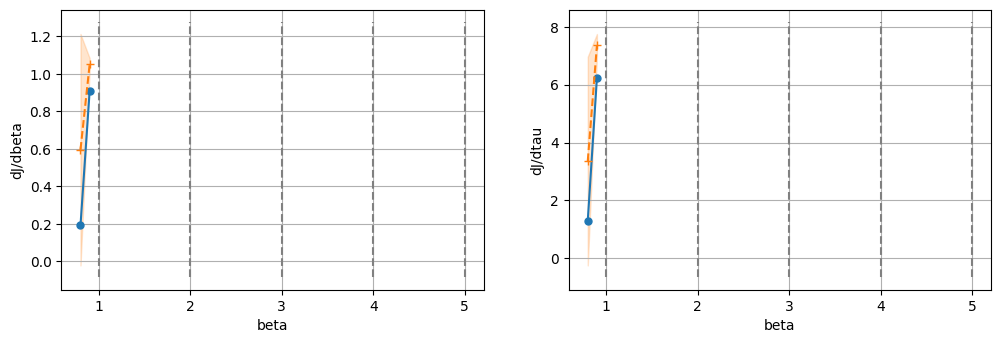

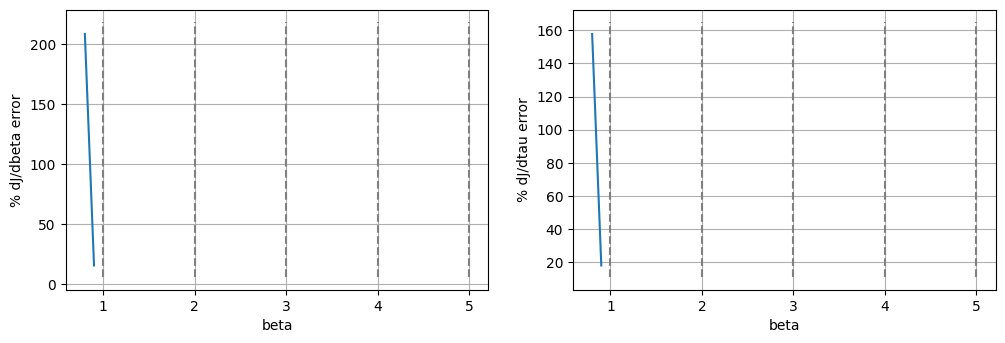

In [52]:
dJdp_mean ={}
dJdp_std ={}
for method_name in methods:
    dJdp_mean[method_name] = np.mean(dJdp["esn"][method_name], axis=0)
    dJdp_std[method_name] = np.std(dJdp["esn"][method_name], axis=0)

linestyle = ['-']*len(methods)
linestyle.extend(['--']*len(methods))
marker = ['o']*len(methods)
marker.extend(['+']*len(methods))
markersize = [5]*len(methods)
markersize.extend([6]*len(methods))

color = ['tab:blue','tab:orange','tab:red','tab:green']
plt.figure(figsize = (12,8))

if hasattr(my_ESN,"tau"):
    param_list = eParam
else:
    param_list = [eParam[param] for param in param_vars]
for i in param_list:

    plt.subplot(2,2,i+1)
    vis.plot_lines(p_list[:,eParam[vary_param]],
                   *[dJdp["true"][method_name][:,i] for method_name in methods],
                   *[dJdp_mean[method_name][:,i] for method_name in methods],
                   linestyle=linestyle,
                   color=color,
                   marker=marker,
                   markersize=markersize
                   )
    
    for m_idx, method_name in enumerate(methods):
        plt.fill_between(p_list[:,eParam[vary_param]], 
                    dJdp_mean[method_name][:,i]-dJdp_std[method_name][:,i],
                    dJdp_mean[method_name][:,i]+dJdp_std[method_name][:,i],
                    alpha=0.2, 
                    antialiased=True,
                    color=color[len(methods)+m_idx])
    ax = plt.gca()
    ylims = ax.get_ylim()
    plt.vlines(vary_param_train, ymin=ylims[0], ymax=ylims[1], color = "grey", linestyles='dashed')

    plt.xlabel(vary_param)
    plt.ylabel(f"dJ/d{i.name}")
plt.figure(figsize = (12,8))
for i in param_list:

    plt.subplot(2,2,i+1)
    error = [100
             *
             np.abs(dJdp_mean[method_name][:,i]-dJdp["true"][method_name][:,i])
             /
             np.abs(dJdp["true"][method_name][:,i]) 
             for method_name in methods]
    
    vis.plot_lines(p_list[:,eParam[vary_param]],
                   *error,
                   )
    ax = plt.gca()
    ylims = ax.get_ylim()
    plt.vlines(vary_param_train, ymin=ylims[0], ymax=ylims[1], color = "grey", linestyles='dashed')
    
    plt.xlabel(vary_param)
    plt.ylabel(f"% dJ/d{i.name} error")


 ## Optimization

In [2]:
energy_dict = pp.unpickle_file('../energy2.pickle')[0]

Text(0, 0.5, 'tau')

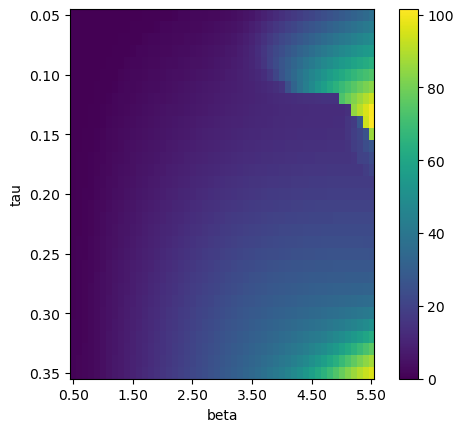

In [14]:
plt.imshow(energy_dict["J"].T,aspect=2)
plt.colorbar()

xticks = np.arange(0,len(energy_dict["beta_list"]),10)
xtick_idx = [int(xtick) for xtick in xticks]
xticklabels = energy_dict["beta_list"][xtick_idx]
xticklabels = [f"{xticklabel:.2f}" for xticklabel in xticklabels]
yticks = np.arange(0,len(energy_dict["tau_list"]),5)
ytick_idx = [int(ytick) for ytick in yticks]
yticklabels = energy_dict["tau_list"][ytick_idx]
yticklabels = [f"{yticklabel:.2f}" for yticklabel in yticklabels]

plt.xticks(xticks,labels=xticklabels)
plt.yticks(yticks,labels=yticklabels)

plt.xlabel('beta')
plt.ylabel('tau')

In [7]:
sim_time = transient_time + washout_time
loop_times = [0]
N = 1000

def J_and_dJdp(p, grad = False):
    global iter
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}

    regime_str = f'beta = {p_sim["beta"]}, tau = {p_sim["tau"]}'
    iter +=1
    print(f'Iteration: {iter}, Regime: {regime_str}')
    
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)

    data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order)
    
    loop_name = list(data.keys())[0]

    if hasattr(my_ESN,"tau"):
        my_ESN.tau = p[eParam.tau]

    # Wash-out phase to get rid of the effects of reservoir states initialised as zero
    # initialise the reservoir states before washout
    x0_washout = np.zeros(my_ESN.N_reservoir)

    # let the ESN run in open-loop for the wash-out
    # get the initial reservoir to start the actual open/closed-loop,
    # which is the last reservoir state
    X_tau = my_ESN.open_loop(x0=x0_washout, U=data[loop_name]["u_washout"], P=data[loop_name]["p_washout"])
    P_grad = data[loop_name]["p_washout"][0]*np.ones((N,1))
    P_grad = np.vstack((data[loop_name]["p_washout"][-my_ESN.N_tau - 1 :, :], P_grad))
    X_pred_grad, Y_pred_grad = my_ESN.closed_loop(X_tau[-my_ESN.N_tau - 1 :, :], N_t=N, P=P_grad)
    J = acoustic_energy(Y_pred_grad[1:,:], N_g)
    if not grad:
        print(f'J = {J}')
        return J
    else:
        dJdp=my_ESN.finite_difference_sensitivity(X_pred_grad, 
                                                Y_pred_grad, 
                                                X_tau, 
                                                P_grad, 
                                                N)
        # dJdp=my_ESN.adjoint_sensitivity(X_pred_grad, 
        #                                 Y_pred_grad, 
        #                                 N,
        #                                 X_tau)
        print(f'J = {J}, dJdp = {dJdp}')
        return J, dJdp

In [8]:
y0 = np.zeros((1,DATA["train"]["u_washout"][0].shape[1]))
eta_1_init = 1.5
y0[0,0] = eta_1_init
u_washout_auto = np.repeat(y0, [len(DATA["train"]["u_washout"][0])], axis = 0)

In [39]:
N = 10000
transient_steps = pp.get_steps(transient_time, network_dt)
# add the transient time that will be discarded later
N_long = transient_steps + N
def get_dJdp(p):
    global iter
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}

    regime_str = f'beta = {p_sim["beta"]}, tau = {p_sim["tau"]}'
    iter +=1
    print(f'Iteration: {iter}, Regime: {regime_str}')

    if hasattr(my_ESN,"tau"):
        my_ESN.tau = p[eParam.tau]

    # Wash-out phase to get rid of the effects of reservoir states initialised as zero
    # initialise the reservoir states before washout
    x0_washout = np.zeros(my_ESN.N_reservoir)

    # let the ESN run in open-loop for the wash-out
    # get the initial reservoir to start the actual open/closed-loop,
    # which is the last reservoir state
    p_washout = p_sim["beta"]*np.ones((u_washout_auto.shape[0],1))
    X_tau = my_ESN.open_loop(x0=x0_washout, U=u_washout_auto, P=p_washout)
    P_grad = p_washout[0]*np.ones((N_long,1))
    P_grad = np.vstack((p_washout[-my_ESN.N_tau - 1 :, :], P_grad))
    X_pred_grad, Y_pred_grad = my_ESN.closed_loop(X_tau[-my_ESN.N_tau - 1 :, :], N_t=N_long, P=P_grad)
    
    # remove transient
    X_tau = X_pred_grad[:transient_steps,:]
    X_pred_grad = X_pred_grad[transient_steps:,:]
    Y_pred_grad = Y_pred_grad[transient_steps:,:]
    P_grad = P_grad[transient_steps:,:]
    
    J = acoustic_energy(Y_pred_grad[1:,:], N_g)
    dJdp=my_ESN.finite_difference_sensitivity(X_pred_grad, 
                                            Y_pred_grad, 
                                            X_tau, 
                                            P_grad, 
                                            N)
    
    # dJdp=my_ESN.adjoint_sensitivity(X_pred_grad, 
    #                                 Y_pred_grad, 
    #                                 N,
    #                                 X_tau)
    print(f'J = {J}, dJdp = {dJdp}')
    return dJdp

In [ ]:
from scipy.optimize import minimize
from functools import partial 
# Optimize using gradient information
p0 = [None]*2
p0[eParam.beta] = 5.0
p0[eParam.tau] = 0.2
bounds = ((0.5,5.5),(0.05,0.35))
global iter
iter = 0
opt = minimize(get_dJdp, p0, method='L-BFGS-B', bounds=bounds, jac=True)

In [42]:
def gradient_descent(start,
                     norm,
                     gradient, 
                     learn_rate, 
                     bounds = None,
                     max_iter = 100, 
                     tol = 0.001):
    x = start
    steps = [start]  # history tracking
    
    x_hat = start/norm
    for _ in range(max_iter):
        grad_hat = norm*gradient(x)

        print(f"beta_hat: {x_hat[0]}, tau_hat = {x_hat[1]}")
        print(f"dJ/dbeta_hat: {grad_hat[0]}, dJ/dtau = {grad_hat[1]}")

        diff = learn_rate*grad_hat

        if np.linalg.norm(diff) < tol:
            break

        x_hat = x_hat - diff

        x = norm*x_hat
        
        # round tau
        x[1] = np.round(x[1], 2)
                        
        # check the bounds
        if bounds:
            x = np.array([max(x[i], bounds[i][0]) for i in range(len(x))])
            x = np.array([min(x[i], bounds[i][1]) for i in range(len(x))])
        
        steps.append(x)  # history tracing

        # if np.linalg.norm(x-x_prev) < tol:
        #     learn_rate = 10*learn_rate

        # x_prev = x
    return steps, x

In [57]:
def adam(start,
        gradient, 
        learn_rate, 
        bounds = None,
        max_iter = 100, 
        tol = 0.001):
    
    x = start
    steps = [start]  # history tracking
    alpha = learn_rate

    beta_1 = 0.9
    beta_2 = 0.999
    epsilon = 1e-8

    m_t = 0
    v_t = 0
    
    for t in np.arange(1, max_iter+1):
        g_t = gradient(x)
        m_t = beta_1*m_t + (1-beta_1)*g_t
        v_t = beta_2*v_t + (1-beta_2)*g_t**2
        m_t_hat = m_t / (1-beta_1**t)
        v_t_hat = v_t / (1-beta_2**t)

        diff = alpha * m_t_hat/np.sqrt(v_t_hat+epsilon)

        if np.linalg.norm(diff) < tol:
            break

        x = x - diff
        
        # round tau
        x[1] = np.round(x[1], 2)
                        
        # check the bounds
        if bounds:
            x = [max(x[i], bounds[i][0]) for i in range(len(x))]
            x = [min(x[i], bounds[i][1]) for i in range(len(x))]
        
        steps.append(x)  # history tracing
  
    return steps, x

In [45]:
p0 = [None]*2
p0[eParam.beta] = 4.0
p0[eParam.tau] = 0.25
global iter
iter = 0

opt = gradient_descent(start = np.array(p0),
                       gradient=get_dJdp, 
                       norm = np.array([3.0,0.2]),
                       bounds = ((0.5,5.5),
                                 (0.05,0.35)),
                       learn_rate=np.array([0.01,0.01]),
                       max_iter=10)

Iteration: 1, Regime: beta = 4.0, tau = 0.25
J = 24.148849838368385, dJdp = [  3.25962028 129.57521843]
beta_hat: 1.3333333333333333, tau_hat = 1.25
dJ/dbeta_hat: 9.778860830422785, dJ/dtau = 25.915043685933735
Iteration: 2, Regime: beta = 3.7066341750873164, tau = 0.2
J = 16.75136115462608, dJdp = [  2.9376096 111.4004218]
beta_hat: 1.2355447250291054, tau_hat = 0.9908495631406626
dJ/dbeta_hat: 8.812828800586201, dJ/dtau = 22.280084359100876
Iteration: 3, Regime: beta = 3.4422493110697303, tau = 0.15
J = 11.28893750258266, dJdp = [ 2.85321262 62.51620796]
beta_hat: 1.1474164370232434, tau_hat = 0.7680487195496539
dJ/dbeta_hat: 8.559637845451105, dJ/dtau = 12.50324159185654
Iteration: 4, Regime: beta = 3.185460175706197, tau = 0.13
J = 9.326295965406784, dJdp = [ 3.43943957 45.69891423]
beta_hat: 1.0618200585687323, tau_hat = 0.6430163036310885
dJ/dbeta_hat: 10.318318716517892, dJ/dtau = 9.13978284561141
Iteration: 5, Regime: beta = 2.8759106142106603, tau = 0.11
J = 7.078397748497562,

In [ ]:
p0 = [None]*2
p0[eParam.beta] = 4.0
p0[eParam.tau] = 0.2
global iter
iter = 0
opt = adam(start = p0,
                gradient=get_dJdp, 
                bounds = ((0.5,5.5),
                            (0.05,0.35)),
                learn_rate=[0.1])

In [71]:
N = 10000
transient_steps = pp.get_steps(transient_time, network_dt)
# add the transient time that will be discarded later
N_long = transient_steps + N

def get_J_dJdp_1(p):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}

    regime_str = f'beta = {p_sim["beta"]}, tau = {p_sim["tau"]}'
    
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)

    data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order)
    
    loop_name = list(data.keys())[0]

    if hasattr(my_ESN,"tau"):
        my_ESN.tau = p[eParam.tau]

    # Wash-out phase to get rid of the effects of reservoir states initialised as zero
    # initialise the reservoir states before washout
    x0_washout = np.zeros(my_ESN.N_reservoir)

    # let the ESN run in open-loop for the wash-out
    # get the initial reservoir to start the actual open/closed-loop,
    # which is the last reservoir state
    X_tau = my_ESN.open_loop(x0=x0_washout, U=data[loop_name]["u_washout"], P=data[loop_name]["p_washout"])
    P_grad = data[loop_name]["p_washout"][0]*np.ones((N,1))
    P_grad = np.vstack((data[loop_name]["p_washout"][-my_ESN.N_tau - 1 :, :], P_grad))
    X_pred_grad, Y_pred_grad = my_ESN.closed_loop(X_tau[-my_ESN.N_tau - 1 :, :], N_t=N, P=P_grad)
    J = acoustic_energy(Y_pred_grad[1:,:], N_g)

    dJdp=my_ESN.finite_difference_sensitivity(X_pred_grad, 
                                            Y_pred_grad, 
                                            X_tau, 
                                            P_grad, 
                                            N)
    return J, dJdp

def get_J_dJdp_2(p):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}

    regime_str = f'beta = {p_sim["beta"]}, tau = {p_sim["tau"]}'
    if hasattr(my_ESN,"tau"):
        my_ESN.tau = p[eParam.tau]

    # Wash-out phase to get rid of the effects of reservoir states initialised as zero
    # initialise the reservoir states before washout
    x0_washout = np.zeros(my_ESN.N_reservoir)

    # let the ESN run in open-loop for the wash-out
    # get the initial reservoir to start the actual open/closed-loop,
    # which is the last reservoir state
    p_washout = p_sim["beta"]*np.ones((u_washout_auto.shape[0],1))
    X_tau = my_ESN.open_loop(x0=x0_washout, U=u_washout_auto, P=p_washout)
    P_grad = p_washout[0]*np.ones((N_long,1))
    P_grad = np.vstack((p_washout[-my_ESN.N_tau - 1 :, :], P_grad))
    X_pred_grad, Y_pred_grad = my_ESN.closed_loop(X_tau[-my_ESN.N_tau - 1 :, :], N_t=N_long, P=P_grad)
    
    # remove transient
    X_tau = X_pred_grad[:transient_steps,:]
    X_pred_grad = X_pred_grad[transient_steps:,:]
    Y_pred_grad = Y_pred_grad[transient_steps:,:]
    P_grad = P_grad[transient_steps:,:]
    
    J = acoustic_energy(Y_pred_grad[1:,:], N_g)

    dJdp=my_ESN.finite_difference_sensitivity(X_pred_grad, 
                                            Y_pred_grad, 
                                            X_tau, 
                                            P_grad, 
                                            N)
    return J, dJdp


In [72]:
p0 = [None]*2
p0[eParam.beta] = 5.0
p0[eParam.tau] = 0.2

print(get_J_dJdp_1(p0))
print(get_J_dJdp_2(p0))

(18.804644157245296, array([  0.36899984, 125.32292556]))
(18.811399344482673, array([  0.37842972, 124.56308985]))


In [30]:
res = pp.unpickle_file(experiment_path/"optimization_results_20231115_110034.pickle")[0]